In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
%matplotlib inline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [33]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [3]:
data=pd.read_csv('AirPassengers.csv')
data

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [4]:
data.columns

Index(['Month', '#Passengers'], dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


<Axes: >

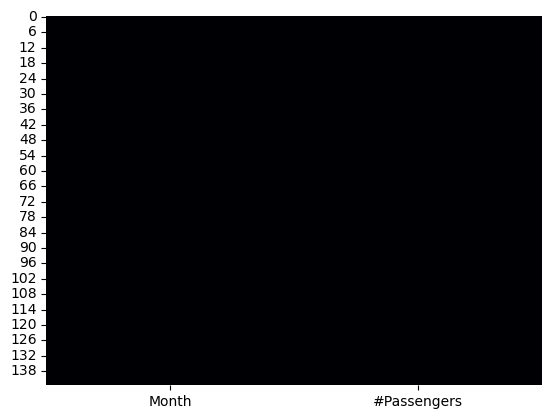

In [6]:
sns.heatmap(data.isnull(),cmap='magma',cbar=False)

In [7]:
pd.options.display.float_format='{:.2f}'.format

In [8]:
data.describe()

,#Passengers
count,144.00
mean,280.30
std,119.97
min,104.00
25%,180.00
50%,265.50
75%,360.50
max,622.00


In [9]:
data['Date']=pd.to_datetime(data['Month'])

In [10]:
data

,Month,#Passengers,Date
0,1949-01,112,1949-01-01
1,1949-02,118,1949-02-01
2,1949-03,132,1949-03-01
3,1949-04,129,1949-04-01
4,1949-05,121,1949-05-01
...,...,...,...
139,1960-08,606,1960-08-01
140,1960-09,508,1960-09-01
141,1960-10,461,1960-10-01
142,1960-11,390,1960-11-01


In [11]:
data=data.drop(columns='Month')
data

,#Passengers,Date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01
...,...,...
139,606,1960-08-01
140,508,1960-09-01
141,461,1960-10-01
142,390,1960-11-01


In [12]:
data=data.set_index("Date")
data

,#Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [13]:
data=data.rename(columns={'#Passengers':'Passengers'})
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


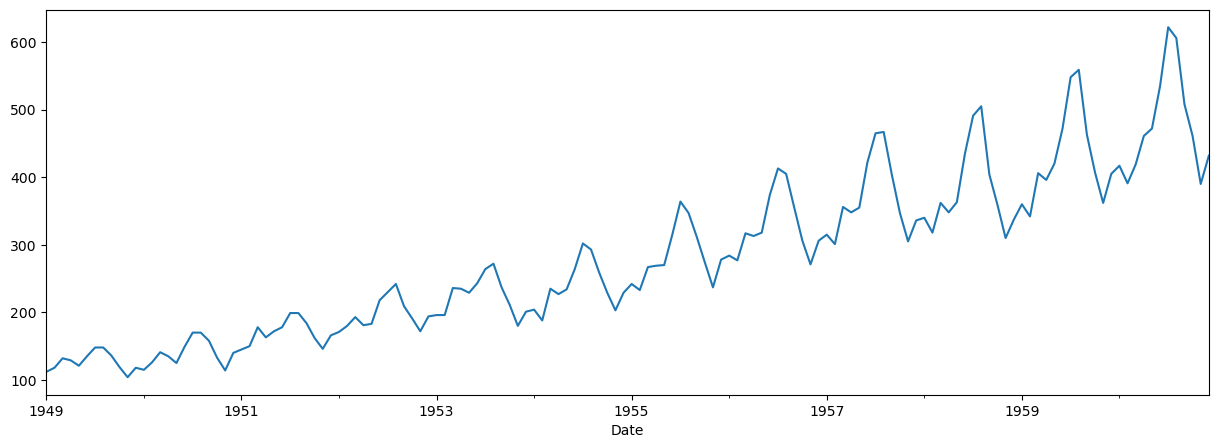

In [14]:
plt.figure(figsize=(15,5))
data["Passengers"].plot();

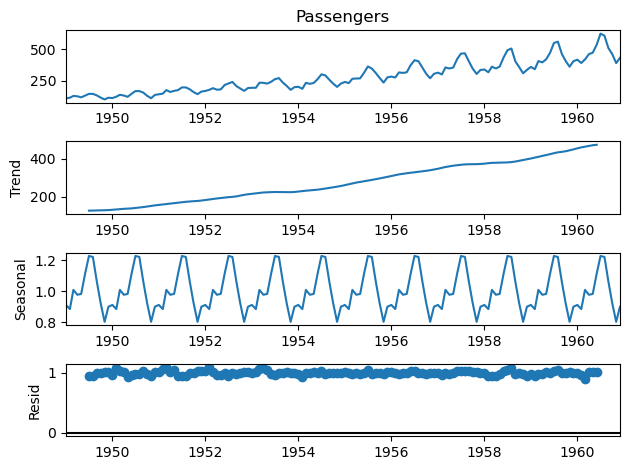

In [15]:
#for trends and seasonality
dec=sm.tsa.seasonal_decompose(data['Passengers'],period=12,model='multiplicative').plot()
plt.show()

In [16]:
def test_stationarity(timeseries):
    MA=timeseries.rolling(window=12).mean()
    MSTD=timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(15,5))
    orig=plt.plot(timeseries,color='blue',label="Original")
    mean=plt.plot(MA,color='red',label="Rolling Mean")
    std=plt.plot(MSTD,color='black',label="Rolling Std")
    
    plt.legend(loc='best')
    plt.title('Rolling mean and std deviation')
    plt.show(block=False)
    
    print("Results of Dickey Fuller Test:")
    dftest=adfuller(timeseries,autolag="AIC")
    print(dftest)
    print("+===========================+")
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value(%s)'%key]=value
    print(dfoutput)

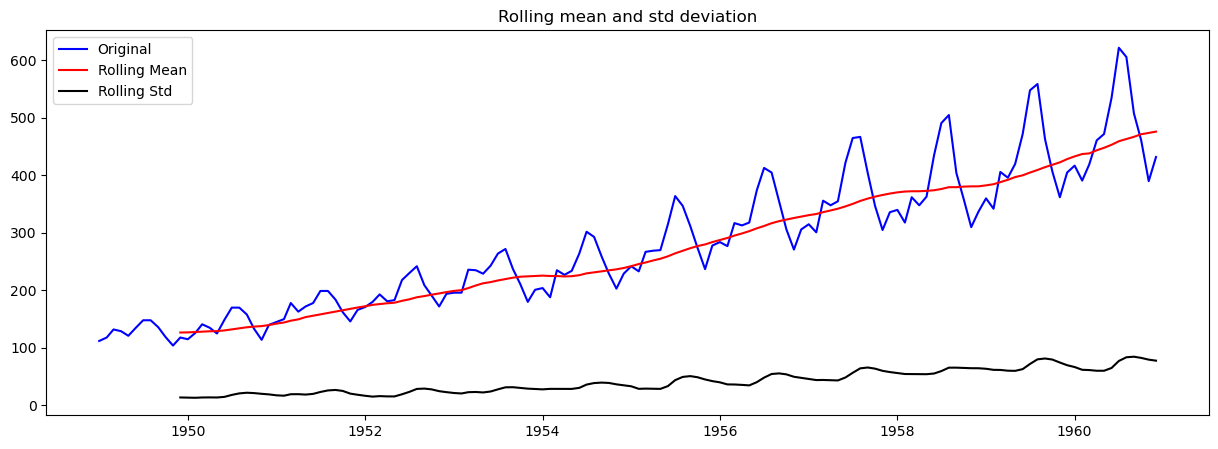

Results of Dickey Fuller Test:
(0.8153688792060423, 0.9918802434376409, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.6929308390189)
+===========================+
Test Statistic                  0.82
p-value                         0.99
#Lags Used                     13.00
Number of Observations used   130.00
Critical Value(1%)             -3.48
Critical Value(5%)             -2.88
Critical Value(10%)            -2.58
dtype: float64


In [17]:
test_stationarity(data["Passengers"])

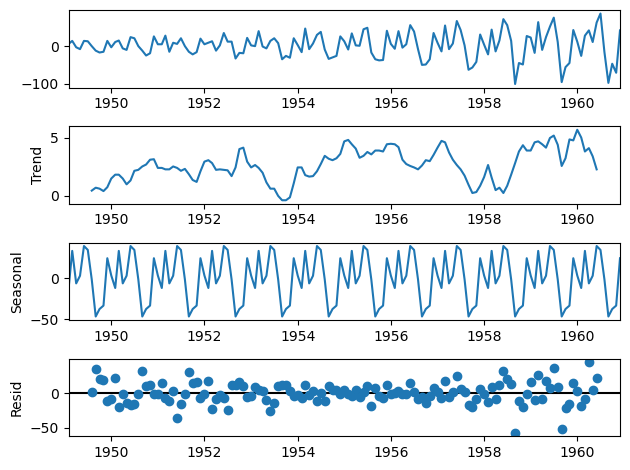

In [18]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

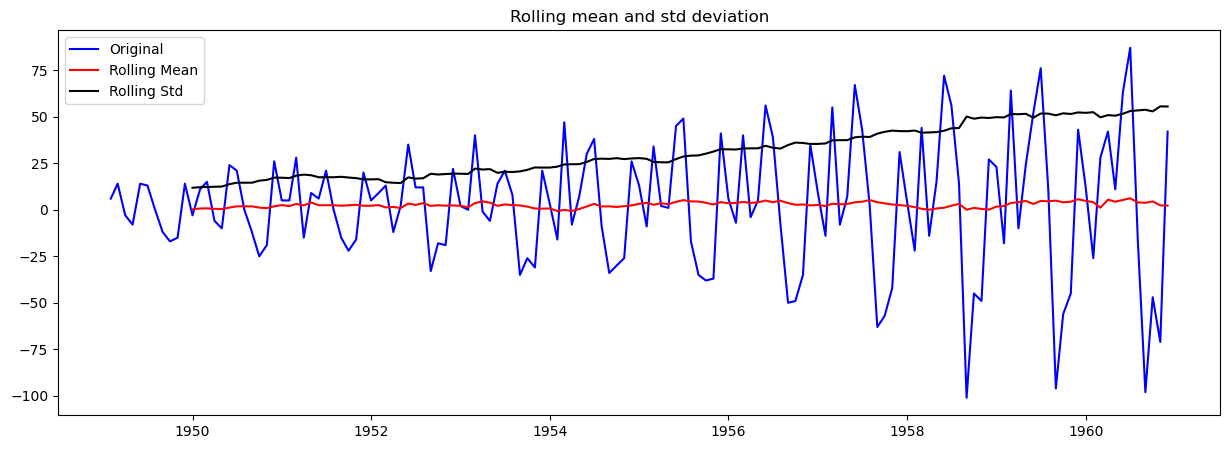

Results of Dickey Fuller Test:
(-2.8292668241699874, 0.05421329028382711, 12, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 988.5069317854085)
+===========================+
Test Statistic                 -2.83
p-value                         0.05
#Lags Used                     12.00
Number of Observations used   130.00
Critical Value(1%)             -3.48
Critical Value(5%)             -2.88
Critical Value(10%)            -2.58
dtype: float64


In [21]:
test_stationarity(data_diff)

In [22]:
def tsplot(y, lags=None,figsize=(12,7),style='bmh'):
    if not isinstance(y,pd.Series):
        y=pd.Series(y)
    with plt.style.context(style):
        fig=plt.figure(figsize=figsize)
        layout=(2,2)
        ts_ax=plt.subplot2grid(layout,(0,0),colspan=2)
        acf_ax=plt.subplot2grid(layout,(1,0))
        pacf_ax=plt.subplot2grid(layout,(1,1))
        y.plot(ax=ts_ax)
        p_value=sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title("time seriea analysis plots \n Dickey-Fuller:p={0:.5f}".format(p_value))
        smt.graphics.plot_acf(y,lags=lags,ax=acf_ax)
        smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax)
        plt.tight_layout()

C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


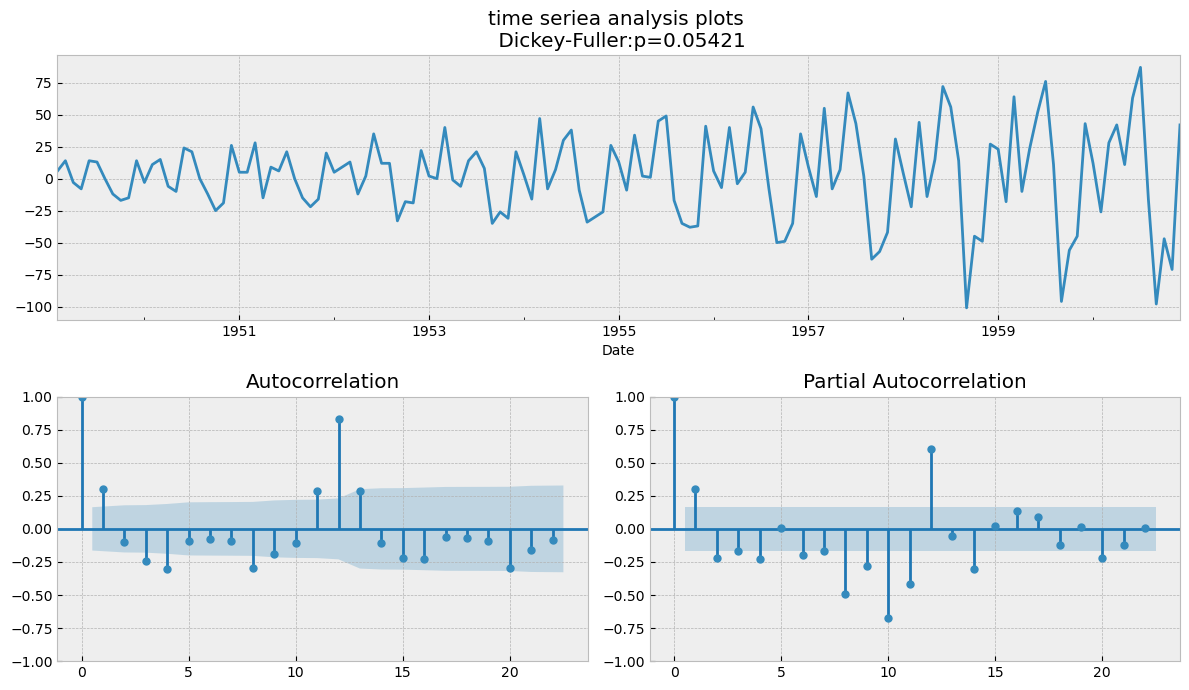

In [24]:
tsplot(data_diff['Passengers'])

In [27]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['Passengers'], order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Fri, 15 Dec 2023   AIC                           1353.347
Time:                        17:20:52   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.061      0.000       1.645       1.725
ar.L2         -0.9549      0.017    -55.421      0.000      -0.989      -0.921
ma.L1         -1.8432      0.124    -14.867      0.0

C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
size=int(len(data)-30)
train,test=data['Passengers'][0:size],data["Passengers"][size:len(data)]


print("\t ARIMA model LIn sample Forecasting \n")

history=[x for x in train]
predictions=[]

for t in range(len(test)):
    model=ARIMA(history,order=(2,1,2))
    model_fit=model.fit()
    output=model_fit.forecast()
    print("output")
    print(output)
    yhat=output[0]
    predictions.append(float(yhat))
    obs=test[t]
    history.append(obs)
    print("predicted= %f,  expected= %f" %(yhat,obs))

	 ARIMA model LIn sample Forecasting 

output
[435.36872887]
predicted= 435.368729,  expected= 491.000000
output
[487.82555953]
predicted= 487.825560,  expected= 505.000000
output
[484.76191423]
predicted= 484.761914,  expected= 404.000000
output
[359.07473862]
predicted= 359.074739,  expected= 359.000000
output
[380.90239774]
predicted= 380.902398,  expected= 310.000000
output
[291.2304132]
predicted= 291.230413,  expected= 337.000000
output
[336.93868493]
predicted= 336.938685,  expected= 360.000000
output
[367.62177121]
predicted= 367.621771,  expected= 342.000000
output
[360.29476093]
predicted= 360.294761,  expected= 406.000000
output
[414.08370175]
predicted= 414.083702,  expected= 396.000000
output
[378.52087775]
predicted= 378.520878,  expected= 420.000000
output
[424.47862084]
predicted= 424.478621,  expected= 472.000000
output
[459.47702686]
predicted= 459.477027,  expected= 548.000000
output
[534.24421732]
predicted= 534.244217,  expected= 559.000000
output
[523.51438532]
pr

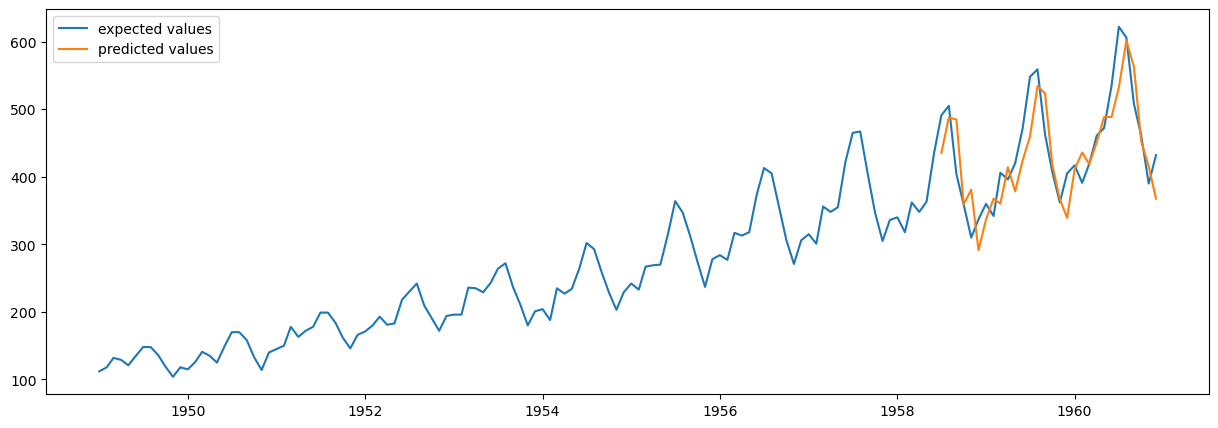

In [35]:
predictions_series=pd.Series(predictions,index=test.index)
fig,axx=plt.subplots(nrows=1,ncols=1,figsize=(15,5))

plt.subplot(1,1,1)

plt.plot(data['Passengers'],label="expected values")
plt.plot(predictions_series,label="predicted values")
plt.legend(loc='upper left')
plt.show()

In [36]:
error=np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE :', error)

Test RMSE : 45.35130621365558


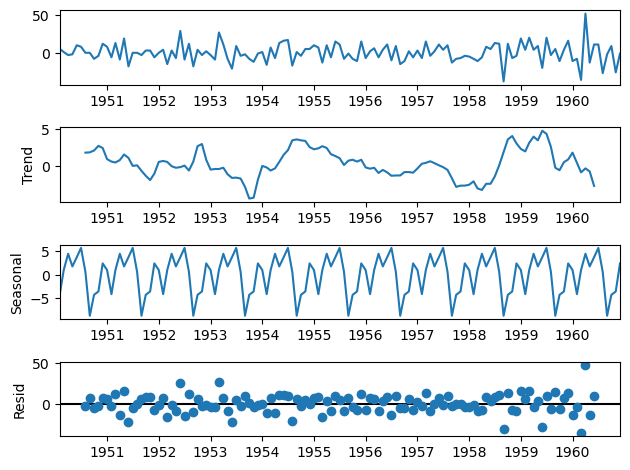

In [38]:
data_diff_seas=data_diff.diff(12)
data_diff_seas=data_diff_seas.dropna()
dec=sm.tsa.seasonal_decompose(data_diff_seas,period=12)
dec.plot()
plt.show()

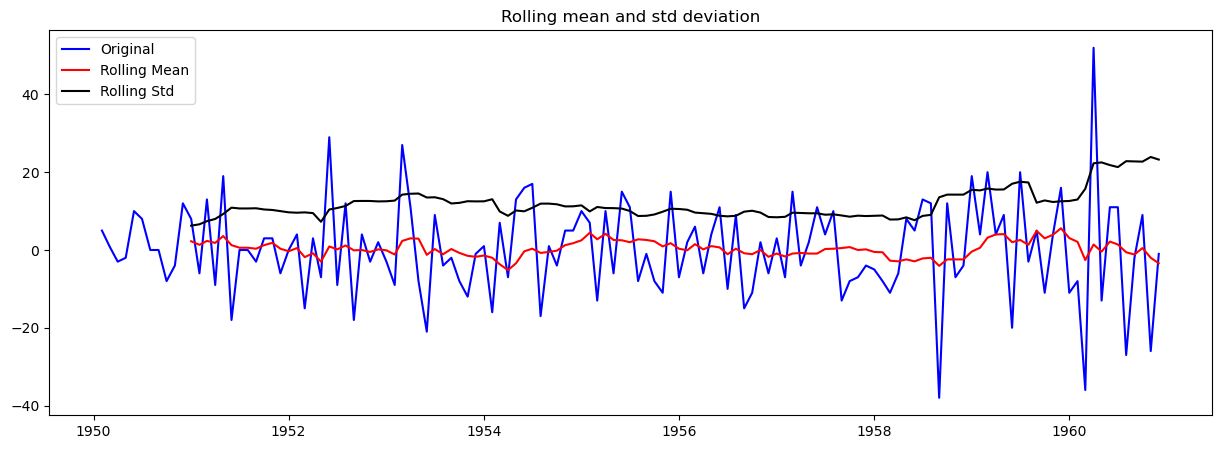

Results of Dickey Fuller Test:
(-15.59561808374634, 1.856511600123444e-28, 0, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 919.8428088960275)
+===========================+
Test Statistic                -15.60
p-value                         0.00
#Lags Used                      0.00
Number of Observations used   130.00
Critical Value(1%)             -3.48
Critical Value(5%)             -2.88
Critical Value(10%)            -2.58
dtype: float64


In [39]:
test_stationarity(data_diff_seas['Passengers'])

C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


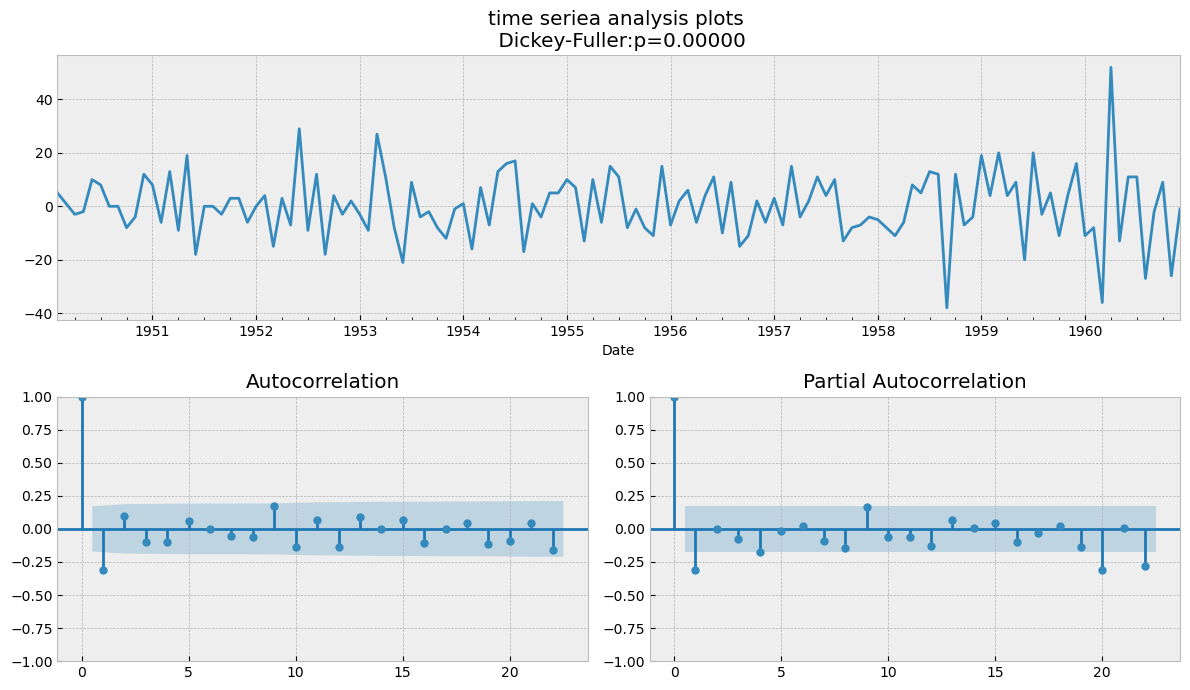

In [40]:
tsplot(data_diff_seas['Passengers'])

In [41]:
model=sm.tsa.statespace.SARIMAX(data['Passengers'],order=(2,1,2),seasonal_order=(0,1,1,12))
model_fit=model.fit()
print(model_fit.summary())

C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -503.968
Date:                              Fri, 15 Dec 2023   AIC                           1019.935
Time:                                      19:33:37   BIC                           1037.186
Sample:                                  01-01-1949   HQIC                          1026.945
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3966      0.422      0.940      0.347      -0.430       1.223
ar.L2          0.35

In [42]:
size=int(len(data)-30)
train,test=data['Passengers'][0:size],data["Passengers"][size:len(data)]


print("\t SARIMA model :In sample Forecasting \n")

history=[x for x in train]
predictions=[]

for t in range(len(test)):
    model=sm.tsa.statespace.SARIMAX(history,order=(2,1,2),seasonal_order=(0,1,1,12))
    model_fit=model.fit()
    output=model_fit.forecast()

    yhat=output[0]
    predictions.append(float(yhat))
    obs=test[t]
    history.append(obs)
    print("predicted= %f,  expected= %f" %(yhat,obs))

	 SARIMA model :In sample Forecasting 

predicted= 479.084141,  expected= 491.000000
predicted= 490.553510,  expected= 505.000000
predicted= 441.276124,  expected= 404.000000
predicted= 357.274710,  expected= 359.000000
predicted= 315.251660,  expected= 310.000000
predicted= 347.832370,  expected= 337.000000
predicted= 344.251223,  expected= 360.000000
predicted= 336.837767,  expected= 342.000000
predicted= 387.593611,  expected= 406.000000
predicted= 387.333490,  expected= 396.000000
predicted= 408.192790,  expected= 420.000000
predicted= 485.988154,  expected= 472.000000
predicted= 529.031344,  expected= 548.000000
predicted= 551.914010,  expected= 559.000000
predicted= 459.061269,  expected= 463.000000
predicted= 411.970101,  expected= 407.000000
predicted= 358.421154,  expected= 362.000000
predicted= 384.945730,  expected= 405.000000
predicted= 420.143792,  expected= 417.000000
predicted= 397.755393,  expected= 391.000000
predicted= 451.335512,  expected= 419.000000
predicted= 415.

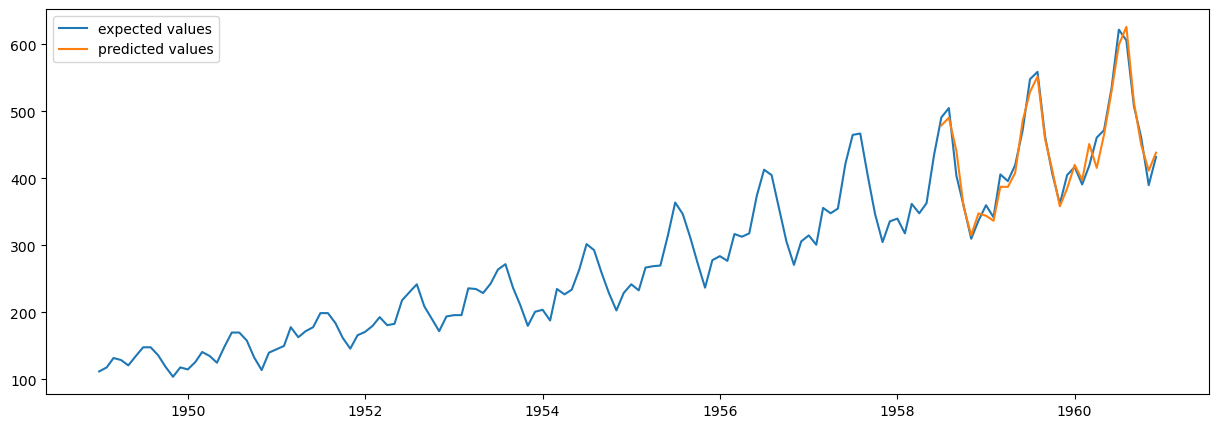

In [43]:
predictions_series=pd.Series(predictions,index=test.index)
fig,axx=plt.subplots(nrows=1,ncols=1,figsize=(15,5))

plt.subplot(1,1,1)

plt.plot(data['Passengers'],label="expected values")
plt.plot(predictions_series,label="predicted values")
plt.legend(loc='upper left')
plt.show()

In [44]:
error=np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE : %.4f' %error)

Test RMSE : 16.9252
